In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
labels_per_class = 'full' # full

### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_MNIST, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_MNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Network architecture

In [8]:
dims = (28,28,1)
n_components= 2

In [9]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

### Test model with just UMAP

In [10]:
from tfumap.semisupervised import find_a_b
from tfumap.umap import convert_distance_to_probability

In [11]:
min_dist = 0.001
_a, _b = find_a_b(min_dist)
_a, _b 

(<tf.Tensor: shape=(), dtype=float32, numpy=1.9290735>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.79150456>)

##### build iterator

In [12]:
from tfumap.semisupervised import build_fuzzy_simplicial_set
from tfumap.umap import compute_cross_entropy, get_graph_elements

In [13]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    #y=Y_masked,
    n_neighbors=n_neighbors,
)

In [14]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 60000])
batch_size

50000

### initialize embedding

In [121]:
from umap.spectral import spectral_layout

from sklearn.utils import check_random_state

random_state = check_random_state(None)
metric = "euclidean"
_metric_kwds = {}
def init_embedding_from_graph(_raw_data, graph, n_components, random_state, metric, _metric_kwds, init="spectral"):
        """ Initialize embedding using graph. This is for direct embeddings. 

        Parameters
        ----------
        init : str, optional
            Type of initialization to use. Either random, or spectral, by default "spectral"

        Returns
        -------
        embedding : np.array
            the initialized embedding
        """
        if isinstance(init, str) and init == "random":
            embedding = random_state.uniform(
                low=-10.0, high=10.0, size=(graph.shape[0], n_components)
            ).astype(np.float32)
        elif isinstance(init, str) and init == "spectral":
            # We add a little noise to avoid local minima for optimization to come

            initialisation = spectral_layout(
                _raw_data,
                graph,
                n_components,
                random_state,
                metric=metric,
                metric_kwds=_metric_kwds,
            )
            expansion = 10.0 / np.abs(initialisation).max()
            embedding = (initialisation * expansion).astype(
                np.float32
            ) + random_state.normal(
                scale=0.0001, size=[graph.shape[0], n_components]
            ).astype(
                np.float32
            )

        else:
            init_data = np.array(init)
            if len(init_data.shape) == 2:
                if np.unique(init_data, axis=0).shape[0] < init_data.shape[0]:
                    tree = KDTree(init_data)
                    dist, ind = tree.query(init_data, k=2)
                    nndist = np.mean(dist[:, 1])
                    embedding = init_data + random_state.normal(
                        scale=0.001 * nndist, size=init_data.shape
                    ).astype(np.float32)
                else:
                    embedding = init_data

        return embedding

In [122]:
embedding = init_embedding_from_graph(X_train, graph, n_components, random_state, metric, _metric_kwds, init="spectral")

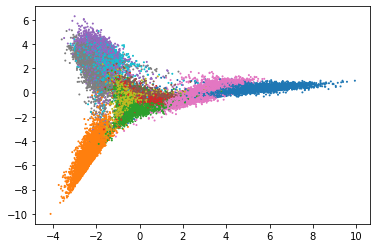

In [123]:
plt.scatter(embedding[:,0], embedding[:,1], c=Y_train, s=1, cmap=plt.cm.tab10)

In [96]:
from tensorflow.keras.layers import Input

In [97]:
n_data = len(X_train)
embedding_layer = tf.keras.layers.Embedding(n_data, n_components, input_length=1)
embedding_layer.build(input_shape=(1,)) # the input_shape here has no effect in the build function
embedding_layer.set_weights([embedding])
encoder = tf.keras.Sequential([embedding_layer])

In [98]:
to_ = tf.constant(edges_to_exp)
from_ = tf.constant(edges_from_exp)

In [99]:
batch_sample = Input(shape=(1), dtype=tf.float32, name = "to_x")

to_x = tf.gather(to_, tf.cast(batch_sample, tf.int32))
from_x = tf.gather(from_, tf.cast(batch_sample, tf.int32))

embedding_to = encoder(to_x)[:,-1,:]
embedding_from = encoder(from_x)[:,-1,:]

embedding_to_from = tf.keras.layers.concatenate([embedding_to, embedding_from],axis=1)
embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name='umap')(embedding_to_from)

model = tf.keras.Model(
    inputs=[batch_sample],
    outputs=[embedding_to_from],#[embedding_to_from],
)

In [100]:
head, tail, weight

(array([ 1482,  8728, 10536, ..., 33072, 34150, 44176], dtype=int32),
 array([    0,     0,     0, ..., 49999, 49999, 49999], dtype=int32),
 array([0.08066241, 0.4961104 , 0.04827981, ..., 0.47979698, 0.5484277 ,
        0.21530996], dtype=float32))

In [101]:
embedding_to_from

<tf.Tensor 'umap/umap_3/Identity:0' shape=(None, 4) dtype=float32>

In [102]:
def umap_loss(weight, batch_size, negative_sample_rate, _a, _b, repulsion_strength = 1.0):
    @tf.function
    def loss(placeholder_y, embed_to_from):
        # split out to/from
        embedding_to, embedding_from = tf.split(embed_to_from, num_or_size_splits=2, axis=1)

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )
        
        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)],
            axis=0,
        )
                
        # compute cross entropy
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=repulsion_strength,
        )
        #ce_loss = ce_loss * alpha
        #return tf.reduce_mean(ce_loss)
        return ce_loss

    return loss

In [103]:
batch_size = len(head)

In [108]:
loss_fn = umap_loss(weight, batch_size, negative_sample_rate, _a, _b)
model.compile(
    optimizer=tf.keras.optimizers.Adadelta(50),
    loss=loss_fn,
    #run_eagerly=True
)

In [109]:
training_variables = encoder.trainable_variables
alpha = tf.Variable(1.0)
opt = tf.keras.optimizers.Adadelta(50)

In [110]:
head, tail, weight

(array([ 1482,  8728, 10536, ..., 33072, 34150, 44176], dtype=int32),
 array([    0,     0,     0, ..., 49999, 49999, 49999], dtype=int32),
 array([0.08066241, 0.4961104 , 0.04827981, ..., 0.47979698, 0.5484277 ,
        0.21530996], dtype=float32))

In [111]:
tf.repeat(weight, 5)

<tf.Tensor: shape=(5147720,), dtype=float32, numpy=
array([0.08066241, 0.08066241, 0.08066241, ..., 0.21530996, 0.21530996,
       0.21530996], dtype=float32)>

In [112]:
embedding_to

<tf.Tensor 'strided_slice_6:0' shape=(None, 2) dtype=float32>

In [113]:
### minimize 

In [118]:
batch_n = 0
for batch_sample, y_ in tqdm(edge_iter):
    with tf.GradientTape() as tape:
        
        embedding_to = encoder(head)[:,-1,:]
        embedding_from = encoder(tail)[:,-1,:]
        
        embedding_to_from = tf.keras.layers.concatenate([embedding_to, embedding_from],axis=1)
        embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name='umap')(embedding_to_from)
        
        loss = loss_fn(y_, embedding_to_from)
        #loss2 = model.compiled_loss(y_, embedding_to_from)
        grads = tape.gradient(loss, training_variables)
        grads = [tf.clip_by_value(grad, -4.0, 4.0) * alpha for grad in grads] # * alpha
        opt.apply_gradients(zip(grads, training_variables))
        
    
    if batch_n % 128 == 0:
        print(batch_n, np.mean(loss.numpy()), np.mean(loss2.numpy()))
        
    batch_n += 1

0 0.12294916 0.10218545
128 0.11904268 0.10218545
256 0.116777964 0.10218545


KeyboardInterrupt: 

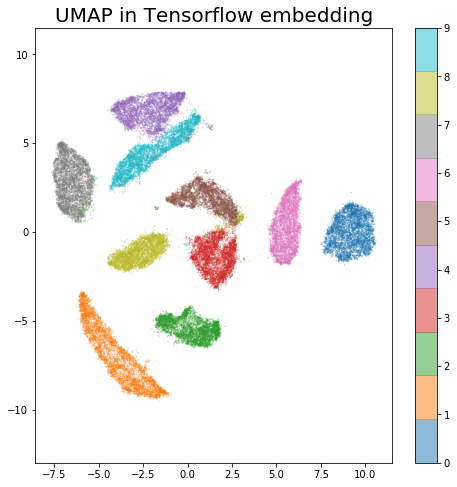

In [119]:
z = encoder.weights[0].numpy()
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);